# Statistics from OSM data

Calculate building statistics from `osmnx` data.


In [1]:
import matplotlib.pyplot as plt
import momepy
import pandas as pd
import seaborn as sns
from cityseer.metrics import layers
from cityseer.tools import graphs, io
from matplotlib import colors
from osmnx import features

/Users/gareth/dev/benchmark-urbanism/cityseer-examples/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To start, follow the same approach as shown in the network examples to create the network.


In [2]:
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 1500
poly_wgs, epsg_code = io.buffered_point_poly(lng, lat, buffer)
G = io.osm_graph_from_poly(poly_wgs)
G = graphs.nx_decompose(G, 50)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 24145/24145 [00:00<00:00, 46421.16it/s]
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 22421/22421 [00:00<00:00, 1110224.90it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 24145/24145 [00:01<00:00, 16175.74it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 22421/22421 [00:00<00:00, 22510.93it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 12164/12164 [00:01<00:00, 9687.27it/s] 
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 7388/7388 [00:00<00:00, 316092.72it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 9003/9003 [00:00<00:00, 739591.42it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 6656/6656 [00:00<00:

Prepare the buildings GeoDataFrame by downloading the data from OpenStreetMap. The `osmnx` [`features_from_polygon`](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_polygon) works well for this purpose. In this instance, we are specifically targeting features that are labelled as an `building`.

It is important to convert the derivative GeoDataFrame to the same CRS as the network.


In [3]:
data_gdf = features.features_from_polygon(poly_wgs, tags={"building": True})
data_gdf = data_gdf.to_crs(G.graph["crs"])
data_gdf.tail()

geometry  \
element id                                                              
way     1374498886  POLYGON ((699072.276 5711987.717, 699073.651 5...   
        1374681344  POLYGON ((700334.357 5710842.473, 700337.684 5...   
        1374681345  POLYGON ((700347.126 5710850.783, 700337.684 5...   
        1374681346  POLYGON ((700335.868 5710827.778, 700339.655 5...   
        1374820282  POLYGON ((699547.129 5710318.314, 699559.064 5...   

                   addr:city addr:postcode    addr:street brand  \
element id                                                        
way     1374498886    London      WC1H 0PD  Gordon Square   NaN   
        1374681344       NaN           NaN            NaN   NaN   
        1374681345       NaN           NaN            NaN   NaN   
        1374681346       NaN           NaN            NaN   NaN   
        1374820282       NaN           NaN            NaN   NaN   

                   brand:wikidata brand:wikipedia    building email  \
element id                                                            
way     1374498886            NaN             NaN       kiosk   NaN   
        1374681344            NaN             NaN  commercial   NaN   
        1374681345            NaN             NaN         yes   NaN   
        1374681346            NaN             NaN  commercial   NaN   
        1374820282            NaN             NaN         yes   NaN   

                            name  ... name:th name:tt name:ur name:vec  \
element id                        ...                                    
way     1374498886  Garden Kiosk  ...     NaN     NaN     NaN      NaN   
        1374681344           NaN  ...     NaN     NaN     NaN      NaN   
        1374681345           NaN  ...     NaN     NaN     NaN      NaN   
        1374681346           NaN  ...     NaN     NaN     NaN      NaN   
        1374820282           NaN  ...     NaN     NaN     NaN      NaN   

                   name:vi name:war name:wuu name:yi name:yue building:flats  
element id                                                                    
way     1374498886     NaN      NaN      NaN     NaN      NaN            NaN  
        1374681344     NaN      NaN      NaN     NaN      NaN            NaN  
        1374681345     NaN      NaN      NaN     NaN      NaN            NaN  
        1374681346     NaN      NaN      NaN     NaN      NaN            NaN  
        1374820282     NaN      NaN      NaN     NaN      NaN            NaN  

[5 rows x 554 columns]

Some preparatory data cleaning is typically necessary. This example extracts the particular rows and columns of interest for the subsequent steps of analysis.


In [4]:
bldg_way = data_gdf.loc["way"]
bldg_way = bldg_way.reset_index(level=0, drop=True)
bldg_way = bldg_way[["geometry"]]
bldg_way.head()

,geometry
0,"POLYGON ((699578.37 5711981.881, 699573.237 57..."
1,"POLYGON ((699509.329 5711958.943, 699502.917 5..."
2,"POLYGON ((699771.225 5711711.453, 699763.808 5..."
3,"POLYGON ((699408.814 5712013.541, 699453.773 5..."
4,"POLYGON ((698517.969 5709739.367, 698517.359 5..."


In [5]:
bldg_rel = data_gdf.loc["relation"]
bldg_rel = bldg_rel.reset_index(level=0, drop=True)
bldg_rel = bldg_rel[["geometry"]]
bldg_rel.head()

,geometry
0,"POLYGON ((698284.165 5711770.625, 698310.212 5..."
1,"POLYGON ((699365.964 5709570.204, 699366.296 5..."
2,"POLYGON ((699421.233 5709690.565, 699431.714 5..."
3,"POLYGON ((699578.614 5709619.103, 699586.076 5..."
4,"POLYGON ((699708.798 5710453.42, 699717.241 57..."


In [6]:
bldgs_gpd = pd.concat([bldg_way, bldg_rel], axis=0)
bldgs_gpd = bldgs_gpd.explode(ignore_index=True)
bldgs_gpd = bldgs_gpd.reset_index(drop=True)
bldgs_gpd.head()

,geometry
0,"POLYGON ((699578.37 5711981.881, 699573.237 57..."
1,"POLYGON ((699509.329 5711958.943, 699502.917 5..."
2,"POLYGON ((699771.225 5711711.453, 699763.808 5..."
3,"POLYGON ((699408.814 5712013.541, 699453.773 5..."
4,"POLYGON ((698517.969 5709739.367, 698517.359 5..."


In [7]:
bldgs_gpd["area"] = bldgs_gpd.geometry.area
bldgs_gpd["perimeter"] = bldgs_gpd.geometry.length
bldgs_gpd["compactness"] = momepy.circular_compactness(bldgs_gpd.geometry)
bldgs_gpd["orientation"] = momepy.orientation(bldgs_gpd.geometry)
bldgs_gpd["shape_index"] = momepy.shape_index(bldgs_gpd.geometry)

In [8]:
bldgs_gpd.geometry.type.unique()

array(['Polygon'], dtype=object)

Use the [`layers.compute_stats`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-stats) method to compute statistics for numeric columns in the `GeoDataFrame`. These are specified with the `stats_column_labels` argument. These statistics are computed over the network using network distances. In the case of weighted variances, the contribution of any particular point is weighted by the distance from the point of measure.


In [9]:
distances = [100, 200]
nodes_gdf, bldgs_gpd = layers.compute_stats(
    bldgs_gpd,
    stats_column_labels=[
        "area",
        "perimeter",
        "compactness",
        "orientation",
        "shape_index",
    ],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing statistics.
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 9768 data entries to network nodes (max_dist: 100).
INFO:cityseer.data:Collected 89659 potential node assignments from data entries.
INFO:cityseer.data:Finished assigning data. 89659 assignments added to 4853 nodes.
INFO:cityseer.graph:Barriers unset and R-tree cleared.
100%|██████████| 5001/5001 [00:01<00:00, 4818.67it/s]
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.


This will generate a set of columns containing `count`, `sum`, `min`, `max`, `mean`, and `var`, in unweighted `nw` and weighted `wt` versions (where applicable) for each of the input distance thresholds.


In [10]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node',
       ...
       'cc_shape_index_sum_200_nw', 'cc_shape_index_sum_200_wt',
       'cc_shape_index_mean_200_nw', 'cc_shape_index_mean_200_wt',
       'cc_shape_index_count_200_nw', 'cc_shape_index_count_200_wt',
       'cc_shape_index_var_200_nw', 'cc_shape_index_var_200_wt',
       'cc_shape_index_max_200', 'cc_shape_index_min_200'],
      dtype='object', length=110)

The result in columns can be explored with conventional Python ecosystem tools such as `seaborn` and `matplotlib`.


<Axes: xlabel='cc_area_mean_100_wt', ylabel='Count'>

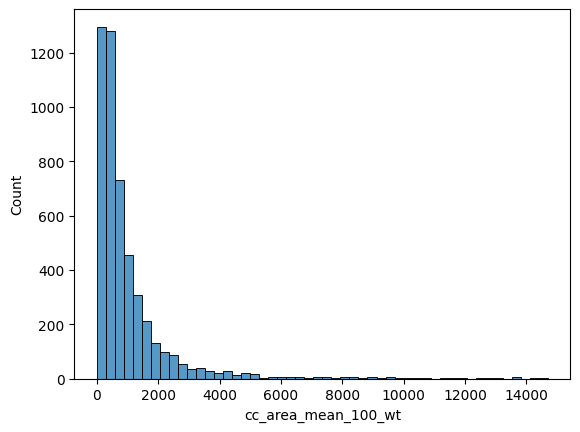

In [11]:
sns.histplot(
    data=nodes_gdf,
    x="cc_area_mean_100_wt",
    bins=50,
)

(np.float64(697102.5282020274),
 np.float64(700585.1041845226),
 np.float64(5709114.861675241),
 np.float64(5712536.396237949))

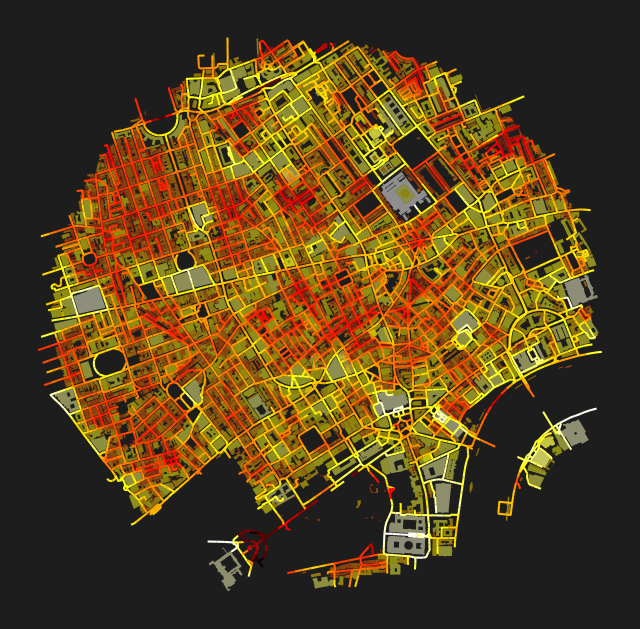

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_area_mean_100_wt",
    cmap="hot",
    legend=False,
    vmin=0,
    vmax=1000,
    norm=colors.LogNorm(),  # Apply log normalization
    ax=ax,
)
bldgs_gpd.plot(
    column="area",
    cmap="hot",
    legend=False,
    vmin=0,
    vmax=1000,
    alpha=0.5,
    norm=colors.LogNorm(),  # Apply log normalization
    ax=ax,
)
ax.axis(False)
